In [12]:
from keras.models import Sequential
from keras.layers import Dropout, Dense
from sklearn.datasets import make_regression
from talos.utils import hidden_layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import sys
import talos

In [13]:
#china dataset that doesn't work
df = pd.read_csv("preproc.csv") 
train, test = train_test_split(df, test_size=0.2)
train = train.drop(['Date','1d'], axis = 1)
test = test.drop(['Date','1d'], axis = 1)

train_y = train[train.columns[1]].values
train_x = train.drop(['PM2.5'], axis = 1).values

test_y = test[test.columns[1]].values
test_x = test.drop(['PM2.5'], axis = 1).values

normalizer = MinMaxScaler(feature_range = (0, 1))
train_x = normalizer.fit_transform(train_x)
test_x = normalizer.fit_transform(test_x)

train_y = train_y.reshape(-1, 1)
train_y = normalizer.fit_transform(train_y)
test_y = test_y.reshape(-1, 1)
test_y = normalizer.fit_transform(test_y)

In [14]:
#base = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
#base = base.dropna()
#base = base.drop('No', axis = 1)
#base = base.drop('year', axis = 1)
#base = base.drop('month', axis = 1)
#base = base.drop('day', axis = 1)
#base = base.drop('hour', axis = 1)
#base = base.drop('cbwd', axis = 1)

#train = base.iloc[:, 1:7].values
#target = base.iloc[:, 0].values

#normalizador = MinMaxScaler(feature_range = (0, 1))
#train = normalizador.fit_transform(train)

#target = target.reshape(-1, 1)
#target = normalizador.fit_transform(target)

In [15]:
# first we have to make sure to input data and params into the function
def create_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    
    # Add first hidden layer with input_dim of input features
    model.add(Dense(params['number_of_neurons'], input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add second hidden layer
    model.add(Dense(params['number_of_neurons'],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add final layer with a linear activation function
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Compile neural network
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['mae'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

In [16]:
# then we can go ahead and set the parameter space
p = {'number_of_neurons':[100],
     'lr': [0.01,0.00001,0.0001,0.001,0.2,0.3,0.5,0.7,1],
     'batch_size': [30],
     'epochs': [100],
     'dropout': [0],
     'kernel_initializer': ['uniform'],
     'optimizer': ['Adam'],
     'losses': ['mae'],
     'activation':['relu'],
     'last_activation': ['linear']}

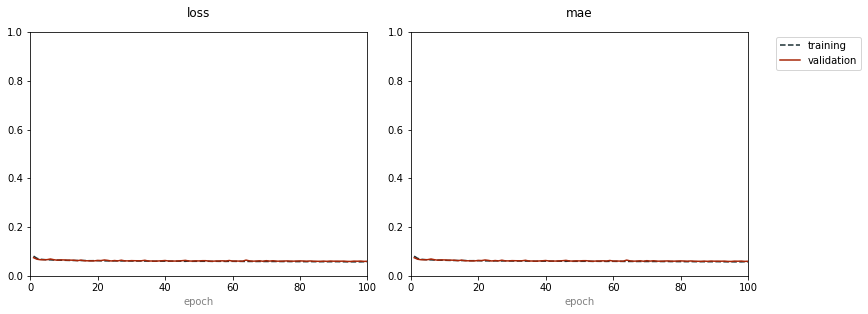

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:24<00:00, 76.06s/it]


In [17]:
# and run the experiment
t = talos.Scan(x=train_x,
               y=train_y,
               model=create_model,
               params=p,
               experiment_name='normalized-learning rate')

In [18]:
analyze_object = talos.Analyze(t)
analyze_object.data

,round_epochs,val_loss,val_mae,loss,mae,activation,batch_size,dropout,epochs,kernel_initializer,last_activation,losses,lr,number_of_neurons,optimizer
0,100,0.059058,0.059058,0.057453,0.057453,relu,30,0,100,uniform,linear,mae,0.01000,100,Adam
1,100,0.058920,0.058920,0.057022,0.057022,relu,30,0,100,uniform,linear,mae,0.00001,100,Adam
2,100,0.059508,0.059508,0.056906,0.056906,relu,30,0,100,uniform,linear,mae,0.00010,100,Adam
3,100,0.060637,0.060637,0.057191,0.057191,relu,30,0,100,uniform,linear,mae,0.00100,100,Adam
4,100,0.060346,0.060346,0.057245,0.057245,relu,30,0,100,uniform,linear,mae,0.20000,100,Adam
5,100,0.059152,0.059152,0.057478,0.057478,relu,30,0,100,uniform,linear,mae,0.30000,100,Adam
6,100,0.059426,0.059426,0.057309,0.057309,relu,30,0,100,uniform,linear,mae,0.50000,100,Adam
7,100,0.059527,0.059527,0.058140,0.058140,relu,30,0,100,uniform,linear,mae,0.70000,100,Adam
8,100,0.059690,0.059690,0.057231,0.057231,relu,30,0,100,uniform,linear,mae,1.00000,100,Adam


In [19]:
analyze_object.low('val_loss')

0.058919574615265626

In [20]:
e = talos.Evaluate(t)
evaluation = e.evaluate(test_x, 
                        test_y, 
                        model_id=None, 
                        folds=10,
                        shuffle=True, 
                        metric='val_loss', 
                        asc=True,
                        task = "continuous")
evaluation

[0.077648972447091,
 0.07818716738523483,
 0.07546800926929939,
 0.07634330596519587,
 0.0828288059757523,
 0.08185626517174494,
 0.0740510796164259,
 0.07722979435765681,
 0.0749153015712628,
 0.07654254686649015]

In [21]:
p = talos.Predict(t)
test_pred_y = p.predict(test_x, metric = 'val_loss', asc = True)

test_pred_y = normalizer.inverse_transform(test_pred_y)
test_y = normalizer.inverse_transform(test_y)

81.58570263230806
53.71537


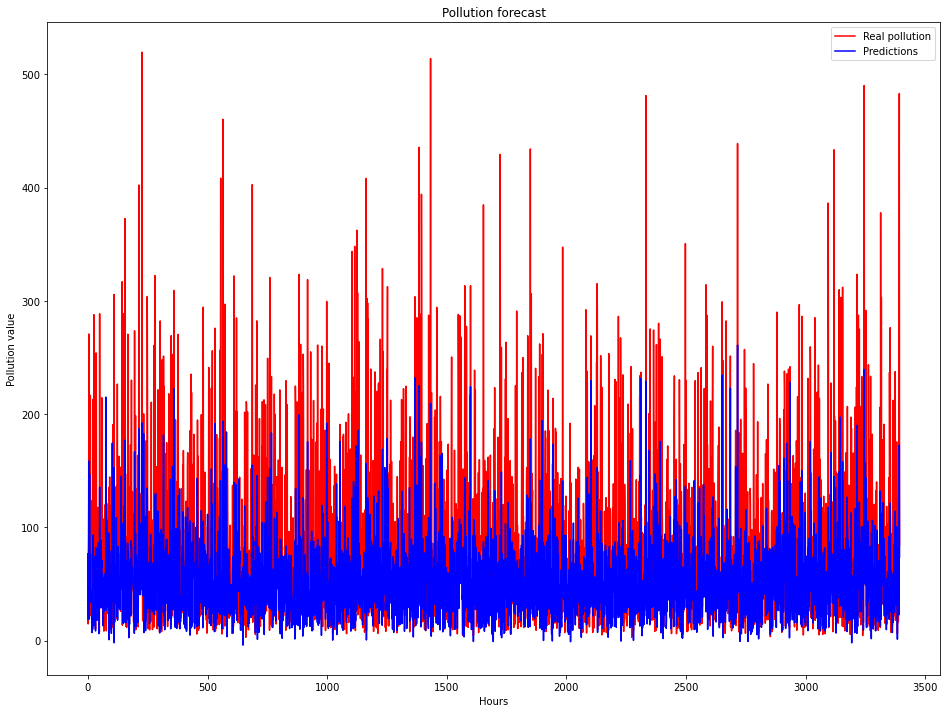

In [22]:
plt.figure(figsize=(16,12))
plt.plot(test_y, color = 'red', label = 'Real pollution')
plt.plot(test_pred_y, color = 'blue', label = 'Predictions')
plt.title('Pollution forecast')
plt.xlabel('Instances')
plt.ylabel('Pollution value')
plt.legend()